In [1]:
import sys
sys.path.insert(0, './..')
import response_contour_analysis.utils.model_handling as model_funcs
import response_contour_analysis.utils.dataset_generation as iso_data
import response_contour_analysis.utils.histogram_analysis as hist_funcs
import response_contour_analysis.utils.plotting as plot_funcs

import utils1

from utils import load_data
import torch
import numpy as np
import proplot as plot
from tqdm import tqdm
import scipy
import scipy.linalg
import matplotlib.pyplot as plt


from models import model
# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)

cpu


/home/lu/.local/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


In [29]:
def sr1_hessian_iter(f, point, distance, n_points, initial_scale=1e-6, random_walk=True, learning_rate=1.0, r=1e-8):
    """Computes SR1 approximation of hessian

    distance: average euclidean distance between initial point and sampled points
    random_walk:
      True: updates will be made along a random walk around initial point.
      False: updates will always be made between inital point and random point
    """
    # We initialize with a hessian matrix with slight positive curvature
    # This is a best practice in BFGS (where you need positive definite hessians).
    # I guess, here we could also initialize with a zero matrix.
    # Actually, in BFGS, you would initialize with a very large hessian (1e6) to
    # enforce small gradient steps until the approximation is useful
    hessian_approximation = torch.eye(np.prod(point.shape), device=DEVICE) * initial_scale

    # we need the data points as vectors
    x_0 = point.flatten()

    def vector_f(x):
        """make f operate on and return vectors"""
        x = x.reshape(point.shape)
        value, gradient = f(x)
        return value, gradient.flatten()

    f0, gradient_0 = vector_f(x_0)

    x_k_minus_1 = x_0
    gradient_k_minus_1 = gradient_0

    for i in tqdm(range(n_points), leave=False):

        # this could probably be more sophisticated
        x_k = x_0 + torch.randn(len(x_k_minus_1), device=DEVICE) / np.sqrt(len(x_k_minus_1)) * distance
        delta_x_k = x_k - x_k_minus_1
        f_k, gradient_k = vector_f(x_k)
        y_k = gradient_k - gradient_k_minus_1

        rank_1_vector = y_k - hessian_approximation @ delta_x_k
        denominator = torch.dot(rank_1_vector, delta_x_k)

        threshold = r * torch.linalg.norm(delta_x_k) * torch.linalg.norm(rank_1_vector)

        if torch.abs(denominator) > threshold:

            hessian_update = (
                torch.outer(rank_1_vector, rank_1_vector)
                / denominator
            )
            hessian_approximation += learning_rate * hessian_update

        else:
            print("SKIP")

        yield hessian_approximation

        if random_walk:
            x_k_minus_1 = x_k
            gradient_k_minus_1 = gradient_k


def sr1_hessian(f, point, distance, n_points, **kwargs):
    for hessian_approximation in sr1_hessian_iter(f, point, distance, int(n_points), **kwargs):
        pass
    return hessian_approximation

In [30]:
def unit_activation(model, image, target_neuron):
    if not torch.is_tensor(image):
        image = torch.tensor(image,device=DEVICE)
    model.zero_grad()
    activations = model(image)[:, target_neuron]
    return activations

def unit_diff_activation(model, image, target_neuron, target_neuron2):
    if not torch.is_tensor(image):
        image = torch.tensor(image,device=DEVICE)
    model.zero_grad()
    activations = model(image)[:, target_neuron]-model(image)[:, target_neuron2]
    return activations

def unit_activation_and_gradient(model, image, target_neuron):
    image.requires_grad = True
    activations = unit_activation(model, image, target_neuron)
    grad = torch.autograd.grad(activations, image)[0]
    return activations, grad

def unit_diff_activation_and_gradient(model, image, target_neuron, target_neuron2):
    image.requires_grad = True
    activations = unit_diff_activation(model, image, target_neuron, target_neuron2)
    grad = torch.autograd.grad(activations, image)[0]
    return activations, grad

def local_response_curvature(act_and_grad_func, hessian, stim):
    '''
    shape_operator - [M, M] dimensional array
    principal_curvatures - [M] dimensional array of curvatures in ascending order
    principal_directions - [M,M] dimensional array,
        where principal_directions[:, i] is the vector corresponding to principal_curvatures[i] 
    '''
    stim_grad = act_and_grad_func(stim)[1].flatten()[:, None] # only need the gradient
    shape_operator = (- hessian / torch.linalg.norm(stim_grad)).detach().cpu().numpy()
    principal_curvatures, principal_directions = np.linalg.eigh(shape_operator)

    return shape_operator, principal_curvatures, principal_directions


In [31]:
def global_response_curvature(model, plane_abscissae, plane_ordinates, experiment_params, orig_img=None, act_is_diff=False):
    contour_dataset = iso_data.get_contour_dataset(
        plane_abscissae,
        plane_ordinates,
        yx_range=experiment_params['yx_range'],
        num_images=experiment_params['num_images'],
        image_scale=experiment_params['image_scale'],
        data_shape=experiment_params['data_shape'],
        return_datapoints=False
    )[0]

    num_neurons_per_plane = 1
    num_edge_images = int(np.sqrt(experiment_params['num_images']))
    num_target_planes = len(contour_dataset['proj_matrix'])
    num_comp_planes = len(contour_dataset['proj_matrix'][0])
    out_shape = (1, num_target_planes, num_comp_planes, num_edge_images, num_edge_images)
    response_images = np.zeros(out_shape)
    for target_plane_id in range(num_target_planes):
        for comp_plane_id in range(num_comp_planes):
            datapoints = iso_data.inject_data(
                contour_dataset['proj_matrix'][target_plane_id][comp_plane_id],
                contour_dataset['proj_datapoints'],
                image_scale=experiment_params['image_scale'],
                data_shape=experiment_params['data_shape']
            )
            if not orig_img is None:
                datapoints = datapoints + orig_img
            if act_is_diff:
                plane_activations = model_funcs.get_normalized_activations(
                    model=model,
                    contour_dataset=[[datapoints]],
                    target_model_ids=[experiment_params['target_model_id']],
                    get_activation_function=unit_diff_activation,
                    activation_function_kwargs={'target_neuron2': experiment_params['adv_neuron_id']}
                )
            else: 
                plane_activations = model_funcs.get_normalized_activations(
                    model=model,
                    contour_dataset=[[datapoints]],
                    target_model_ids=[experiment_params['target_model_id']],
                    get_activation_function=unit_activation
                )
            response_images[0, target_plane_id, comp_plane_id, ...] = np.squeeze(plane_activations)
    del plane_activations

    num_y, num_x = response_images.shape[3:]
    yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
    y_pts, x_pts = yx_pts
    y_range = max(y_pts) - min(y_pts)
    x_range = max(x_pts) - min(x_pts)
    bounds = experiment_params['bounds']
    if bounds is None: 
        y_scale_factor =  y_range / num_y
        x_scale_factor =  x_range / num_x
        start_y = start_x = 0
        end_y = num_y
        end_x = num_x
    else: # assumes input is square, centered around origin, and the bounds are also centered
        y_bounds, x_bounds = bounds
        y_bound_range = max(y_bounds) - min(y_bounds)
        x_bound_range = max(x_bounds) - min(x_bounds)
        y_trim = 0.5 * y_bound_range / y_range
        x_trim = 0.5 * x_bound_range / x_range
        start_y = int(np.floor(y_trim*num_y))
        end_y = int(np.ceil(3*y_trim*num_y))
        start_x = int(np.floor(x_trim*num_x))
        end_x = int(np.ceil(3*x_trim*num_x))
        new_num_y = end_y - start_y
        new_num_x = end_x - start_x
        y_pts_trim = y_pts[start_y:end_y]
        x_pts_trim = x_pts[start_x:end_x]
        new_y_range = max(y_pts_trim) - min(y_pts_trim)
        new_x_range = max(x_pts_trim) - min(x_pts_trim)
        y_scale_factor =  new_y_range / new_num_y
        x_scale_factor =  new_x_range / new_num_x

    preproc_resp_images = response_images[0, :, :, start_y:end_y, start_x:end_x].copy()
    iso_curvatures, iso_fits, iso_contours = hist_funcs.iso_response_curvature_poly_fits(
        preproc_resp_images,
        target=experiment_params['target'],
        target_is_act=experiment_params['target_is_act'],
        yx_scale=[y_scale_factor, x_scale_factor])
    
    return contour_dataset, response_images, iso_curvatures, iso_fits, iso_contours

In [478]:
img_n = 8
# load data

data = np.load('../data/madry_l2_5.npy', allow_pickle=True).item()
advs = data['advs'][img_n:img_n+1]
pert_lengths = data['pert_lengths']
classes = data['adv_class']
dirs = data['dirs'][img_n:img_n+1]
images = torch.tensor(data['images'][img_n:img_n+1], device=DEVICE).detach()
labels = data['labels']
pert_lengths = data['pert_lengths']

In [479]:
# load models
model_natural = model.madry()
model_madry = model.madry()
model_random = model.madry()
model_natural.load_state_dict(torch.load('./../models/natural.pt', map_location=DEVICE))
model_madry.load_state_dict(torch.load('./../models/adv_trained_l2.pt', map_location=DEVICE))
model_random.load_state_dict(torch.load('./../models/random.pt', map_location=DEVICE))
# model_natural.to(dev())
# model_madry.to(dev())
model_ = model.madry()
model_.load_state_dict(torch.load('./../models/adv_trained_l2.pt', map_location=DEVICE))

<All keys matched successfully>

In [480]:
act_is_diff = False

# d_set ='MNIST'
# images, labels = load_data(n_images, bounds=(0., 1.), d_set=d_set, random=False)

experiment_params = dict()
experiment_params['target_neuron_id'] = labels[img_n]
experiment_params['adv_neuron_id'] = int(classes[img_n,0])

if act_is_diff:
    act_func = lambda x: unit_diff_activation_and_gradient(model_, x, experiment_params['target_model_id'], experiment_params['adv_neuron_id'])
    image_stack = torch.tensor(advs).reshape(images.shape)
else:
    act_func = lambda x: unit_activation_and_gradient(model_, x, experiment_params['target_model_id'])
    image_stack = images.detach()

average_image_norm = np.mean(np.linalg.norm(image_stack.reshape(image_stack.shape[0], -1), axis=1))

img_vmin = image_stack.min().cpu().detach().numpy()
img_vmax = image_stack.max().cpu().detach().numpy()






experiment_params['unit_ids'] = np.arange(10)
experiment_params['target_model_id'] = experiment_params['unit_ids'][experiment_params['target_neuron_id']]

experiment_params['data_shape'] = list(image_stack[0, ...].shape)
experiment_params['image_scale'] = 1#average_image_norm
experiment_params['x_range'] = (-2.0, 2.0)
experiment_params['y_range'] = (-2.0, 2.0)
experiment_params['num_images'] = int(30**2)
experiment_params['num_planes'] = 1
experiment_params['target_is_act'] = False
experiment_params['bounds'] = ((-.9, .9), (-.9, .9))
experiment_params['hessian_dist'] = experiment_params['image_scale']
experiment_params['hessian_num_pts'] = 1000#2e5
experiment_params['hessian_lr'] = 1e-4
experiment_params['target'] = 0.
yx_range = experiment_params['yx_range'] = (experiment_params['y_range'], experiment_params['x_range'])



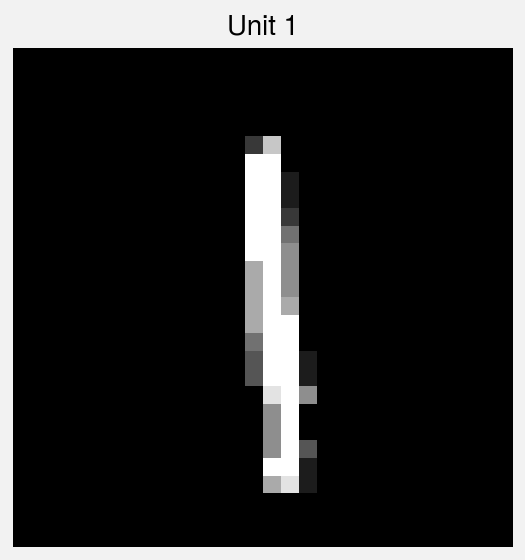

In [481]:
# Plot the MEIs
nrows = 5
fig, axs = plot.subplots(nrows=1, ncols=1, hspace=-0.75)
for i, ax in enumerate(axs):
    ax.imshow(image_stack[i, ...].cpu().detach().numpy().squeeze(), cmap='Gray', vmin=img_vmin, vmax=img_vmax)
    unit_id = experiment_params['target_model_id']
    ax.format(title=f'Unit {unit_id}')
    ax.axis('off')

In [482]:
act, grad = act_func(image_stack)
# act, grad = unit_diff_activation_and_gradient(model_, image_stack, experiment_params['target_model_id'],experiment_params['adv_neuron_id'])
target_torch_image = (image_stack + grad*experiment_params['image_scale']*experiment_params['target']*experiment_params['x_range'][1]).detach()
mei_hessian = sr1_hessian(
    act_func, target_torch_image,
    distance=experiment_params['hessian_dist'],
    n_points=experiment_params['hessian_num_pts'],
    random_walk=False,
    learning_rate=experiment_params['hessian_lr'])
np_mei_hessian = mei_hessian.detach().cpu().numpy()
mei_hessian_eigen_values, mei_hessian_eigen_vectors = scipy.linalg.eigh(np_mei_hessian)

In [483]:
mei_shape_operator, mei_principal_curvatures, mei_principal_directions = local_response_curvature(
    act_func, mei_hessian, target_torch_image)

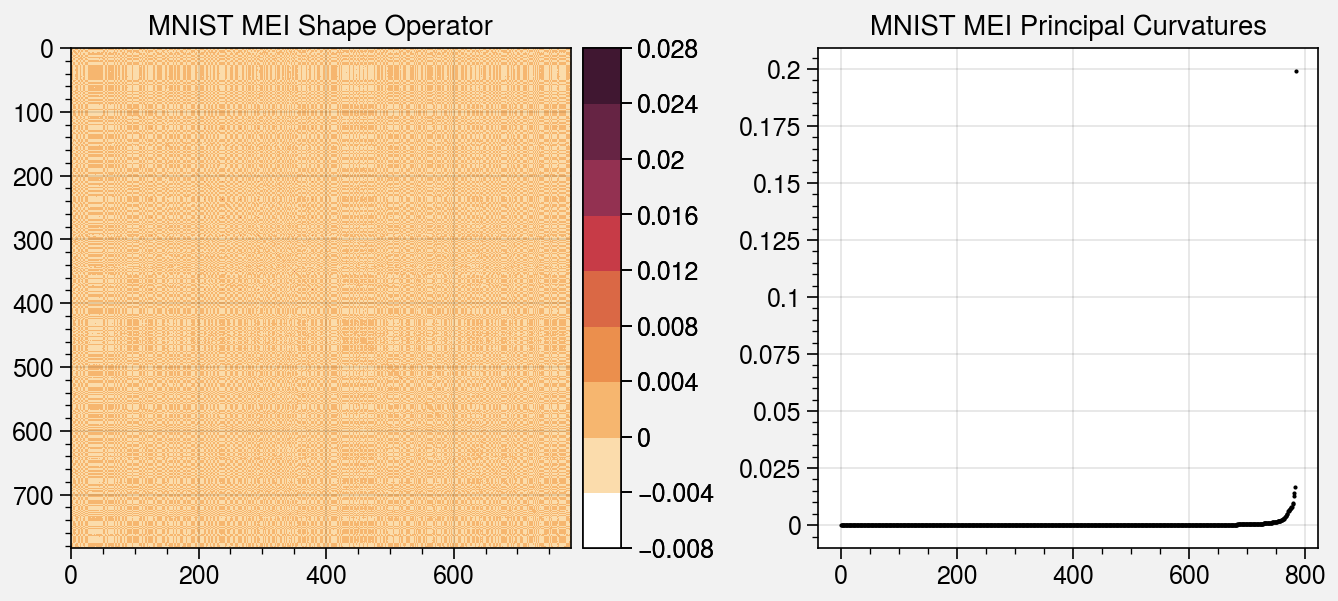

In [484]:
fig, axs = plot.subplots(nrows=1, ncols=2, sharey=False, sharex=False)
mappable = axs[0].imshow(mei_shape_operator, vmin=mei_shape_operator.min(), vmax=mei_shape_operator.max())
axs[0].colorbar(mappable)
axs[0].format(title='MNIST MEI Shape Operator')
axs[1].scatter(mei_principal_curvatures, s=0.8, c='k')
axs[1].format(title='MNIST MEI Principal Curvatures')
plot.show()

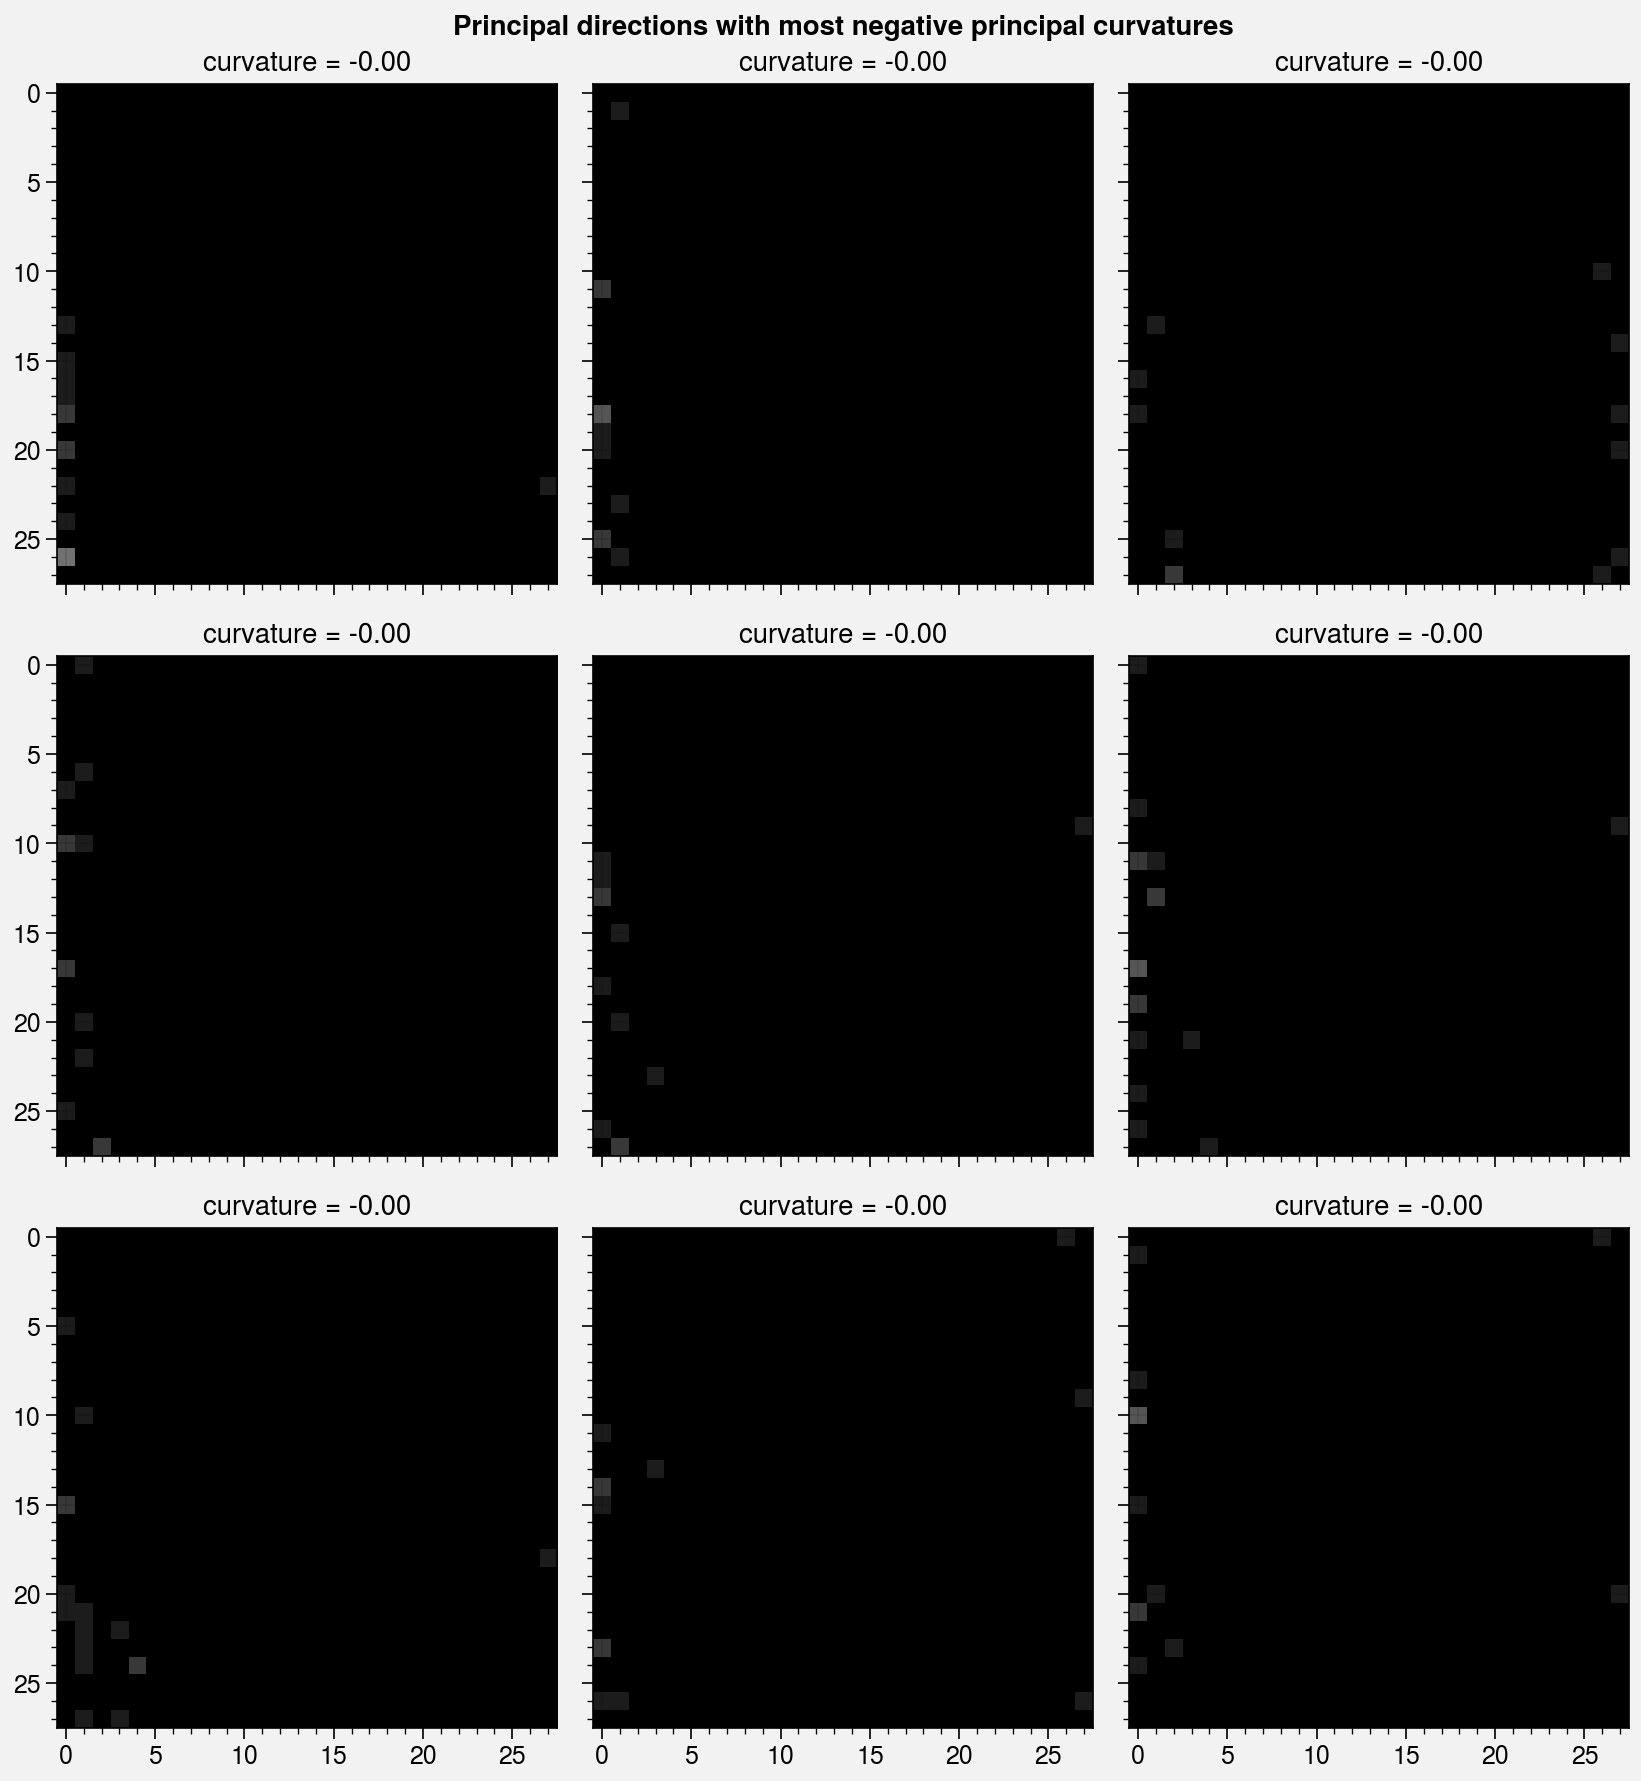

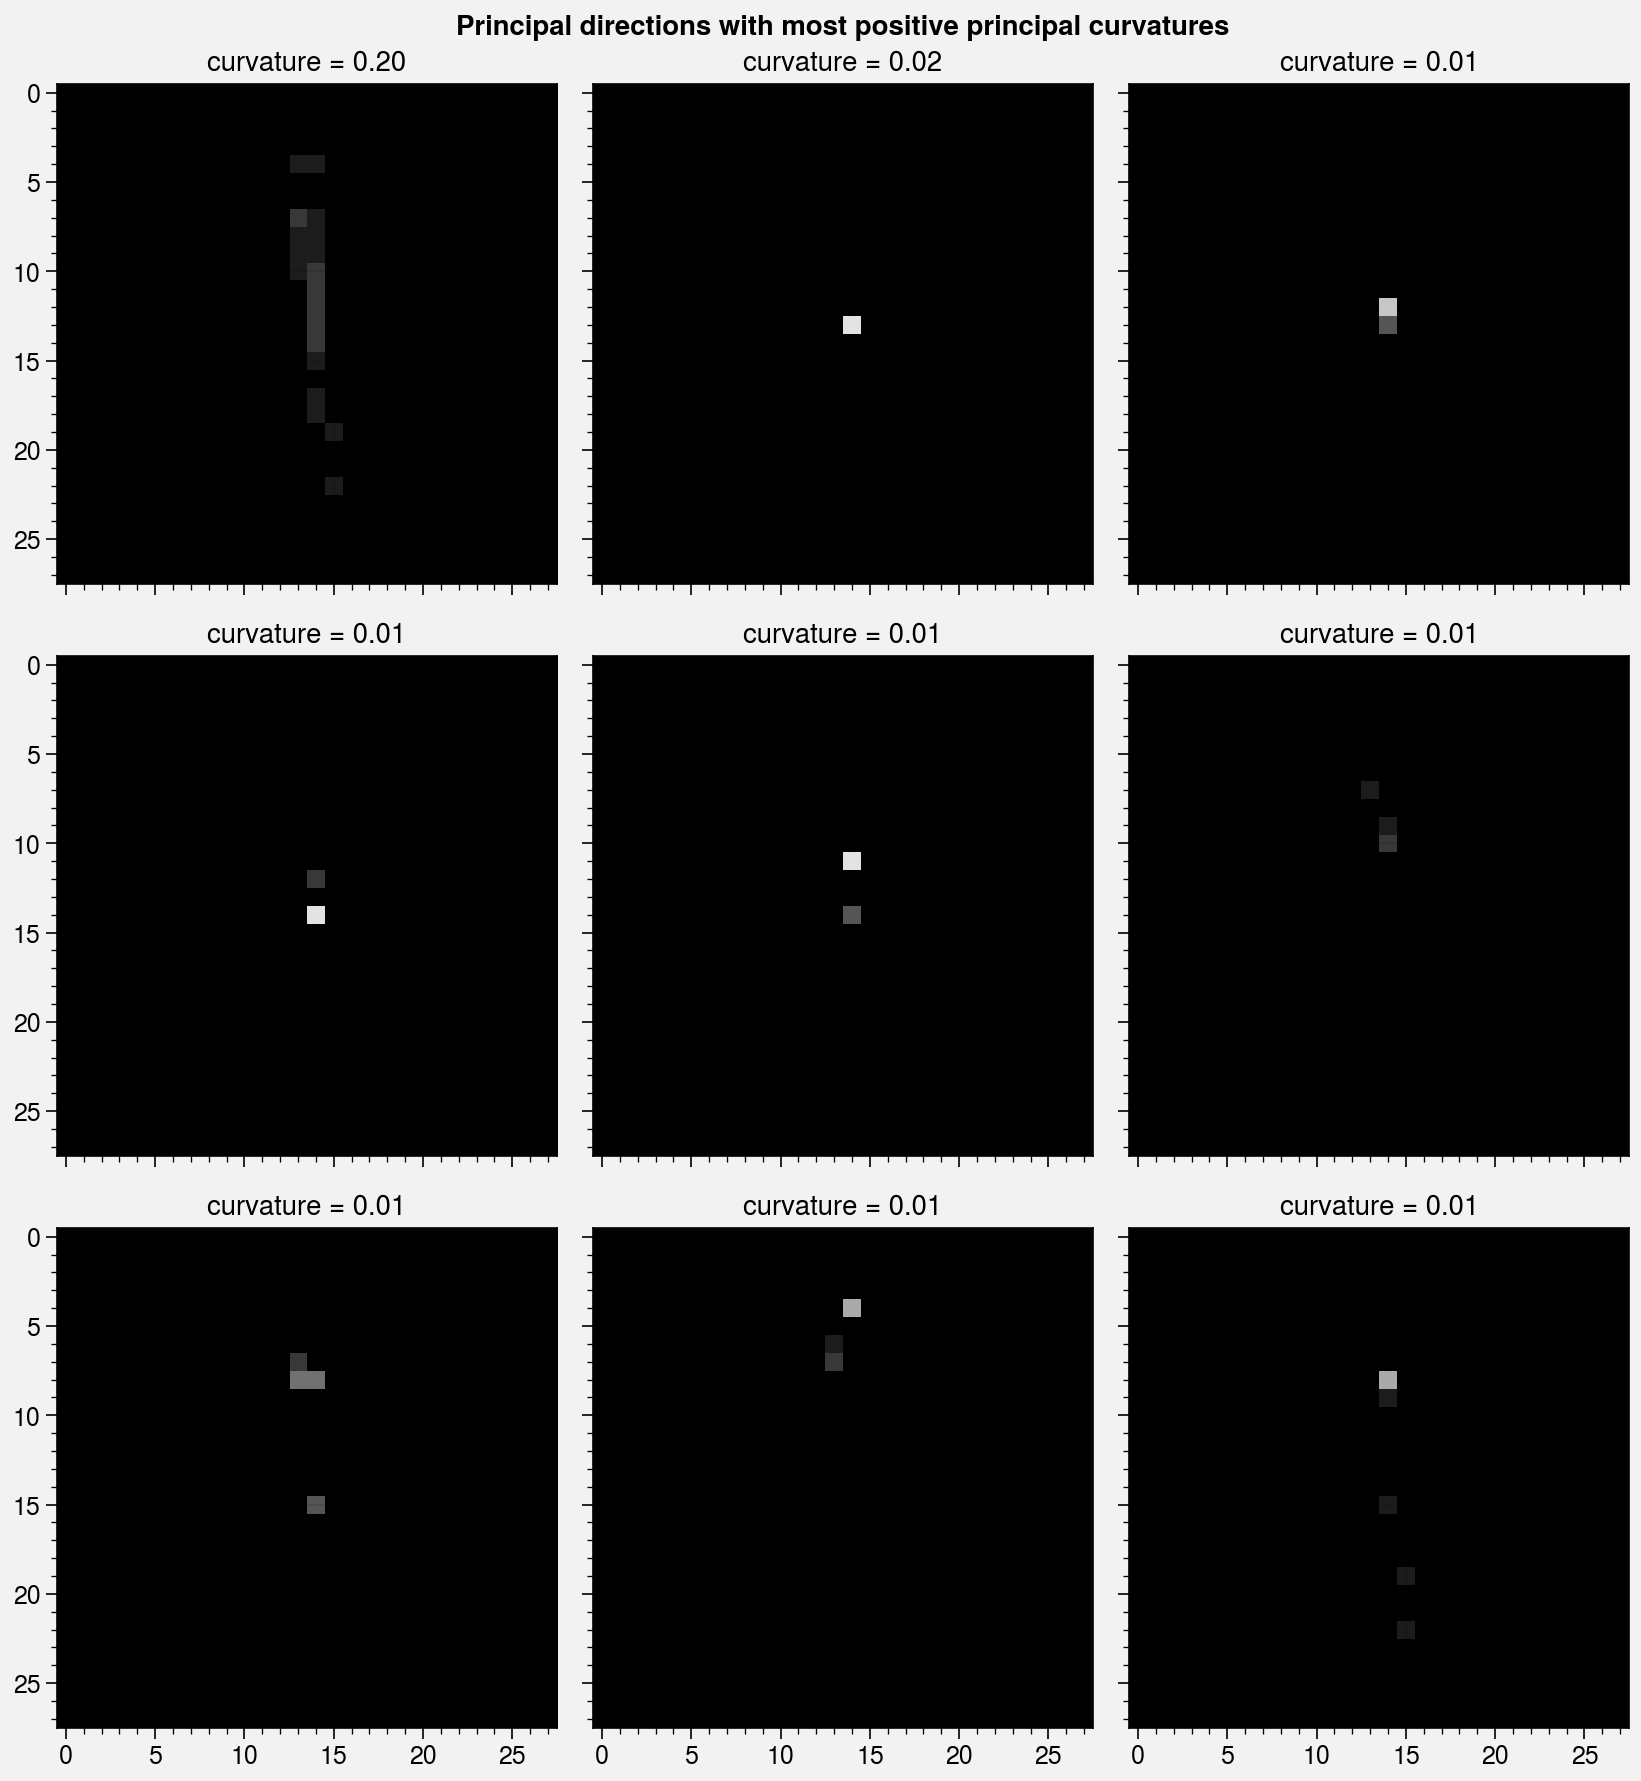

In [485]:
fig, axs = plot.subplots(nrows=3, ncols=3)
for i, ax in enumerate(axs):
    ax.imshow(experiment_params['image_scale'] * mei_principal_directions[:, i].reshape(experiment_params['data_shape']).squeeze(), cmap='Gray',
              vmin=img_vmin, vmax=img_vmax)
    ax.format(title=f'curvature = {mei_principal_curvatures[i]:.2f}')
axs.format(suptitle='Principal directions with most negative principal curvatures')
plot.show()
#fig.savefig('outputs/mouse_MEIs_smallest_principal_curvature_directions.png', transparent=False, bbox_inches='tight', dpi=200)

fig, axs = plot.subplots(nrows=3, ncols=3)
for i, ax in enumerate(axs):
    i = -(i+1)
    ax.imshow(experiment_params['image_scale'] * mei_principal_directions[:, i].reshape(experiment_params['data_shape']).squeeze(), cmap='Gray',
              vmin=img_vmin, vmax=img_vmax)
    ax.format(title=f'curvature = {mei_principal_curvatures[i]:.2f}')
axs.format(suptitle='Principal directions with most positive principal curvatures')
plot.show()
#fig.savefig('outputs/mouse_MEIs_largest_principal_curvature_directions.png', transparent=False, bbox_inches='tight', dpi=200)

In [491]:
M = (data['dirs'])[:,0].reshape(-1,dirs[:,0].shape[-1])
u,s,v = np.linalg.svd(M)

np_image = image_stack.flatten().cpu().detach().numpy().reshape((28,28))
orig_img = np_image #np.ones(np_mei.shape).astype('float32')*0.5)
# direction_indices = [-1, -20, -40, -60, -80, -100, -120, -140]
# direction_indices = [0, 20, 40, 60, 80, 100, 120, 140]
# direction_indices = -np.arange(1,20)
direction_indices = np.arange(0,20)
# direction_indices = range(dirs.shape[1])
# direction_indices = range(len(mei_principal_directions))

# horizontal axes for the planes
act, grad = act_func(image_stack)
plane_abscissae = [iso_data.l2_normalize(grad.cpu().detach().numpy())] 

# vertical axes for the planes
plane_ordinates = [iso_data.l2_normalize(v[direction_index])
                            for direction_index in direction_indices] 

# plane_ordinates = [iso_data.l2_normalize(mei_principal_directions[:, direction_index])
#                       for direction_index in direction_indices] 
# global curvature estimate
contour_dataset, response_images, iso_curvatures, iso_fits, iso_contours = global_response_curvature(
    model_, plane_abscissae, plane_ordinates, experiment_params, orig_img=orig_img, act_is_diff=act_is_diff)

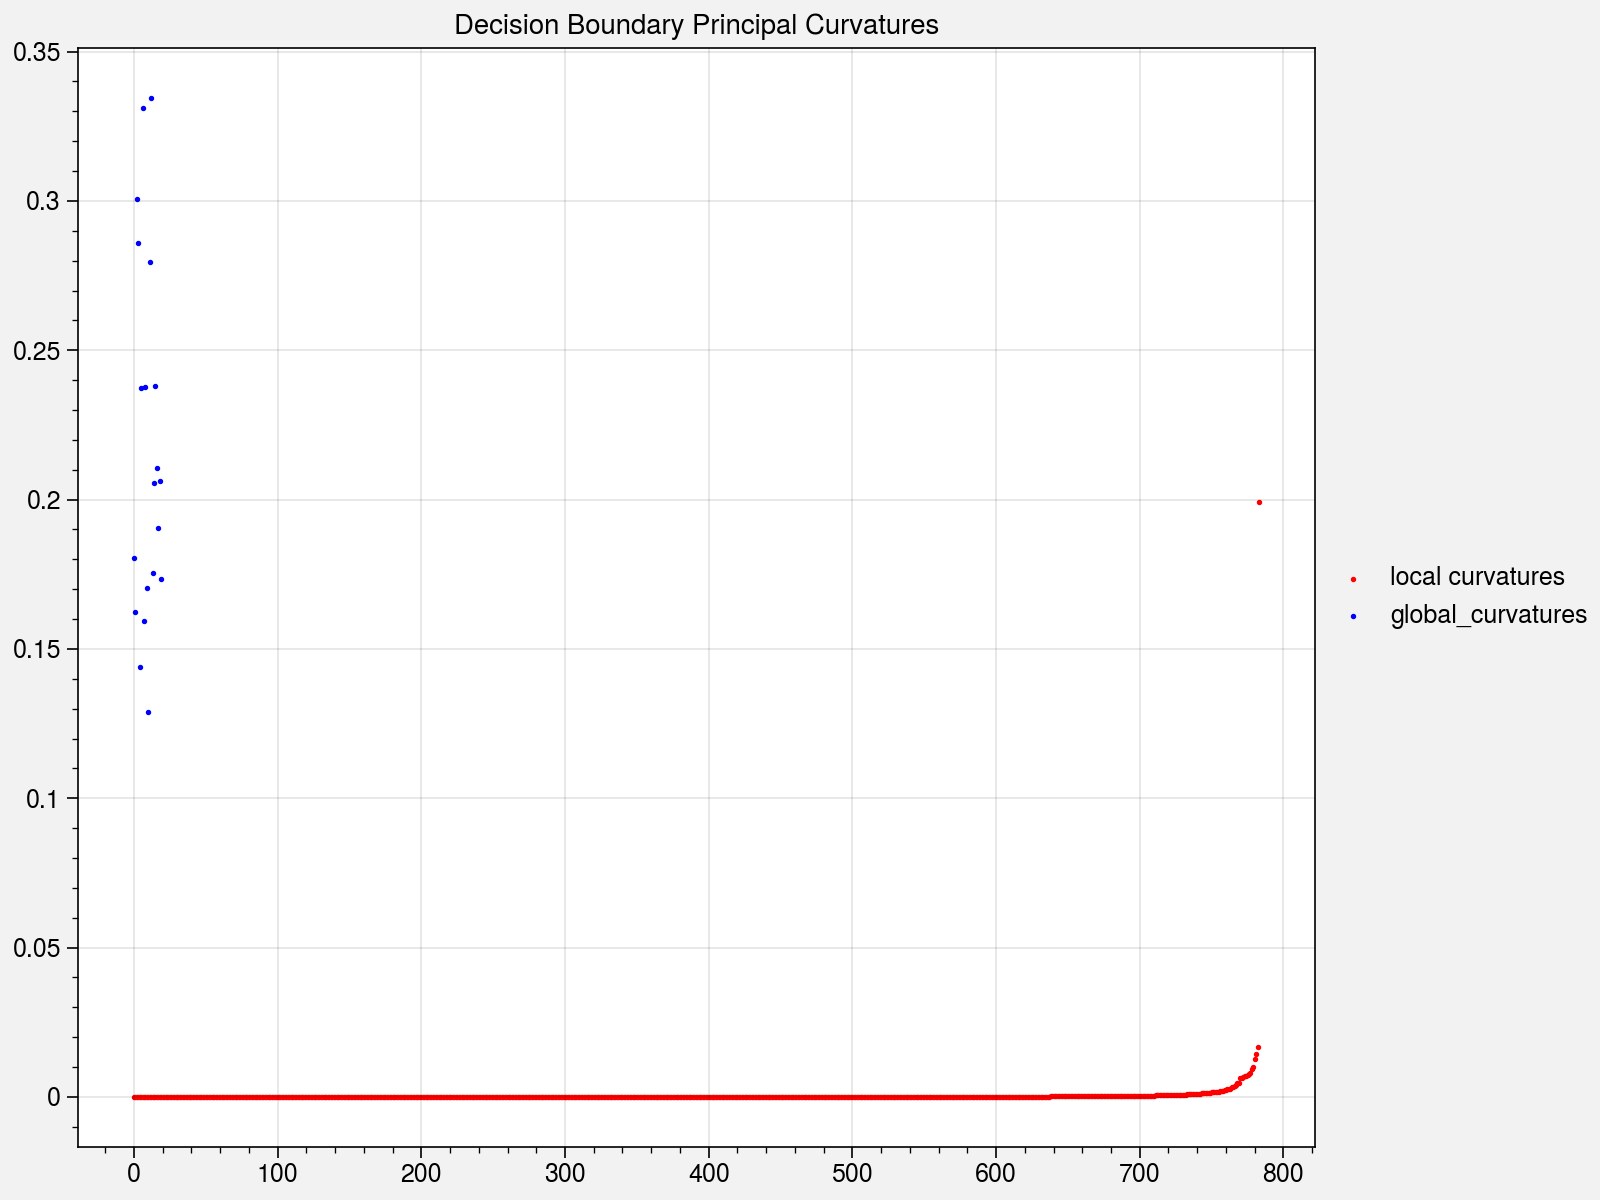

In [492]:
fig, axs = plot.subplots(nrows=1, ncols=1, sharey=False, sharex=False, figsize=(8,6))
axs[0].scatter(mei_principal_curvatures, s=1.8, c='r', label='local curvatures',legend='r')
axs[0].scatter(direction_indices,np.array(iso_curvatures[0]), s=1.8, c='b', label='global_curvatures',legend='r', legend_kw={'ncols': 1, 'frame': False})
axs[0].format(title='Decision Boundary Principal Curvatures')
plot.show()


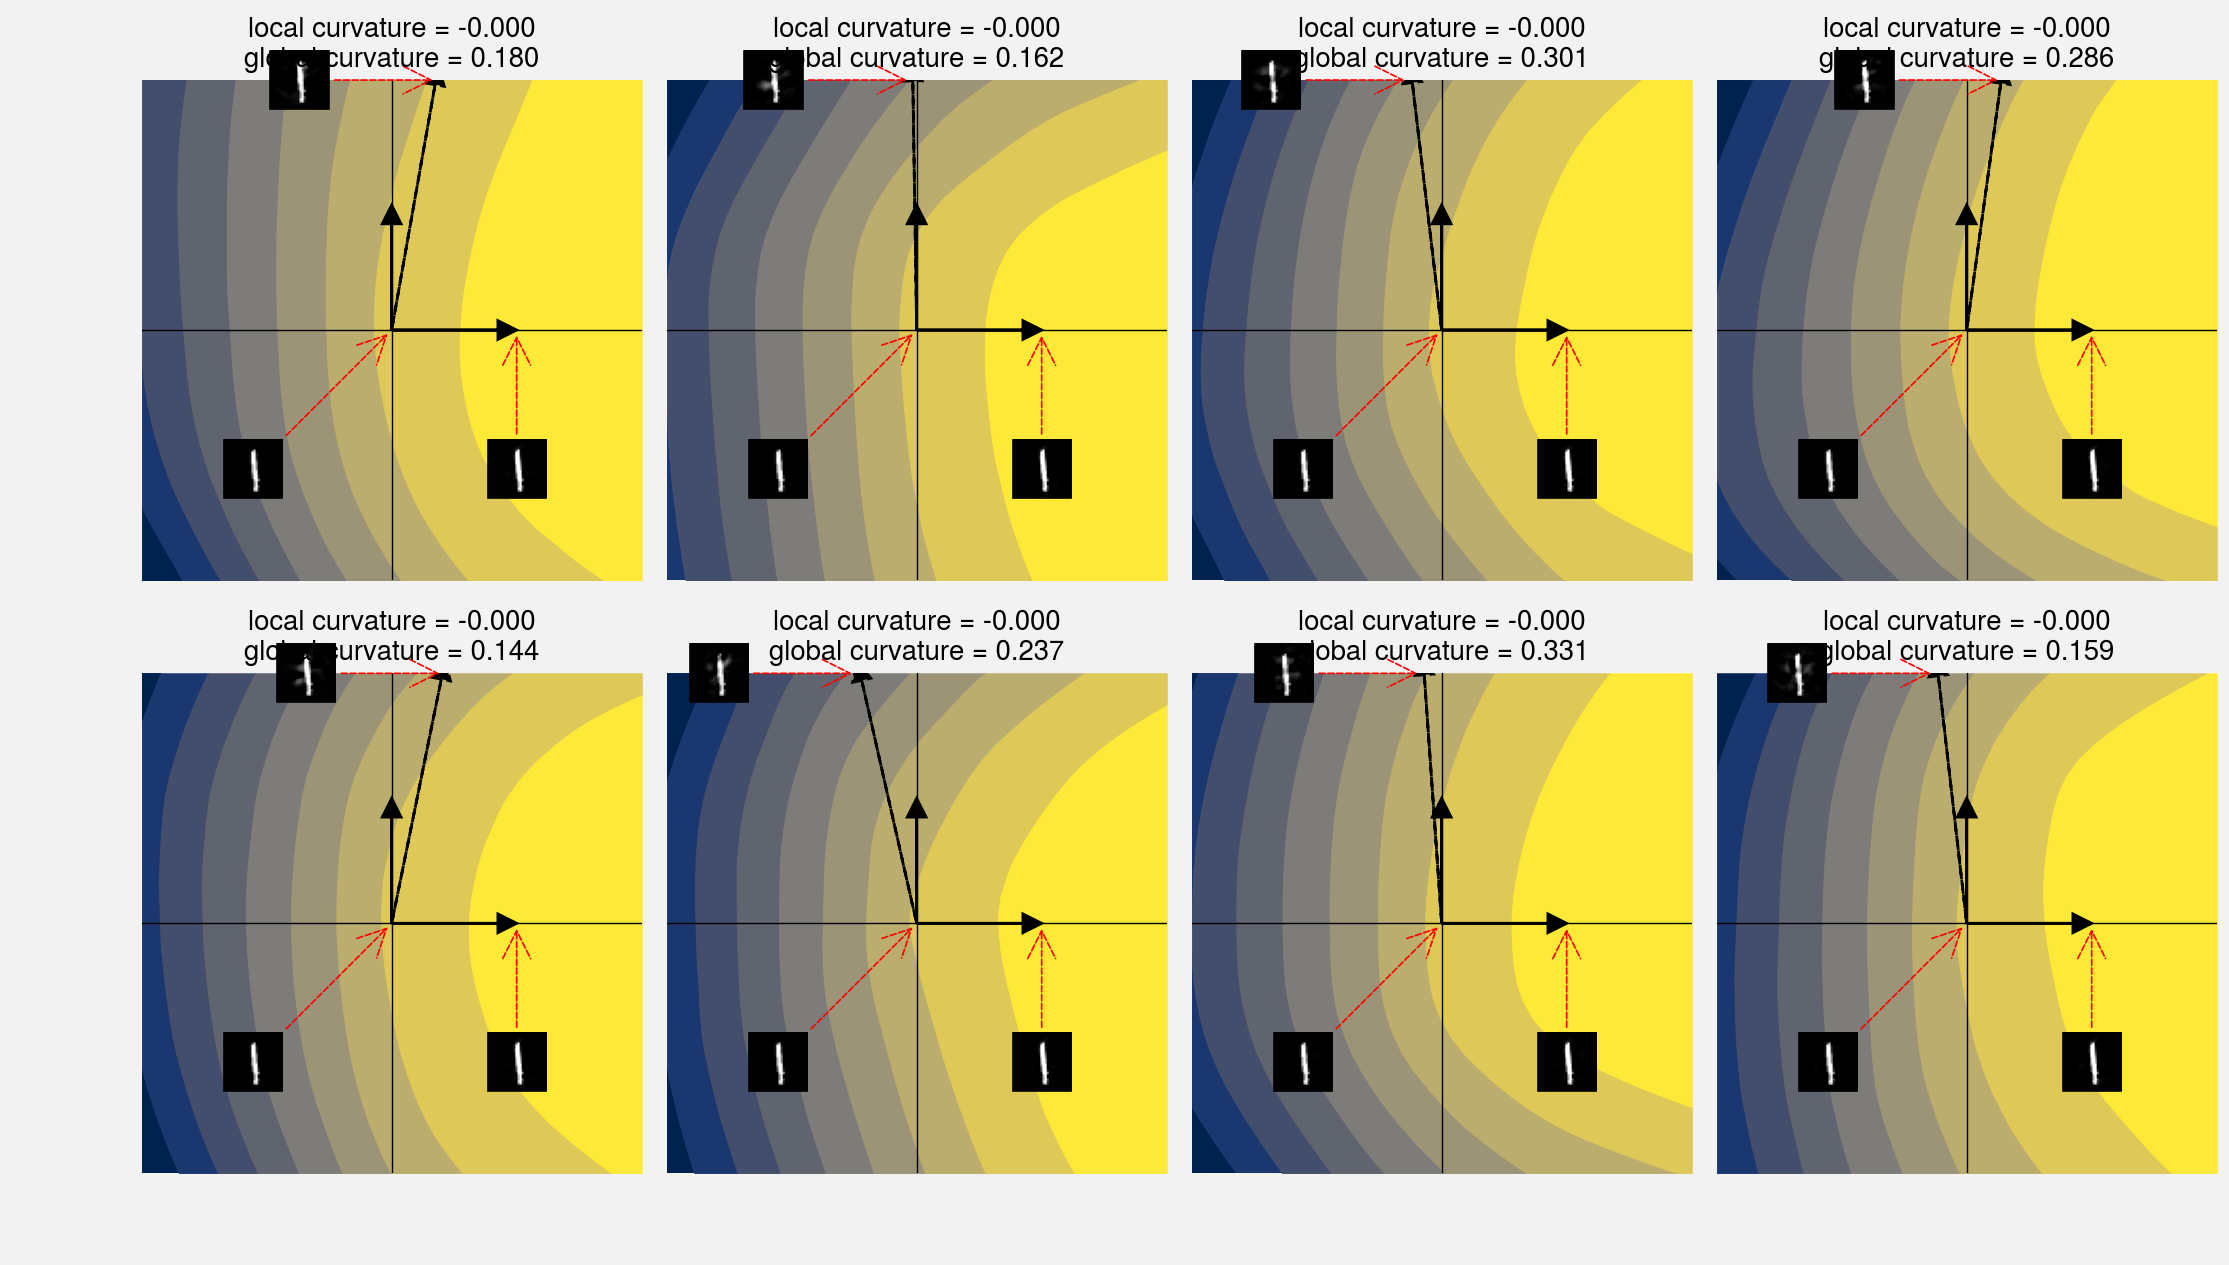

In [493]:
num_plot_comparisons = 10#len(direction_indices)
num_plot_cols = 4
num_plot_rows = num_plot_comparisons // num_plot_cols
fig, axs = plot.subplots(nrows=num_plot_rows, ncols=num_plot_cols)
target_plane_id = 0
comp_plane_id = 0
for row_id in range(num_plot_rows):
    for col_id in range(num_plot_cols):
        ax = plot_funcs.clear_axis(axs[row_id, col_id])
        yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
        proj_vects = (
            contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
            contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id]*pert_lengths[img_n,0],
            contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
        )
        response_image = response_images[0, target_plane_id, comp_plane_id, ...]
        response_image = (response_image - response_image.min()) / (response_image.max() - response_image.min())
        num_images_per_edge = int(np.sqrt(experiment_params['num_images']))
        cv_slope = proj_vects[1][1] / proj_vects[1][0]
        global_curvature = np.round(iso_curvatures[target_plane_id][comp_plane_id], 3)
        local_curvature = np.round(mei_principal_curvatures[direction_indices[comp_plane_id]], 3)
        contsf = utils1.plot_contours(
            ax,
            response_image,
            iso_contours[target_plane_id][comp_plane_id],
            iso_fits[target_plane_id][comp_plane_id],
            yx_pts,
            experiment_params['yx_range'],
            proj_vects,
            num_levels=10,
            plot_fits=False,
            title=f'local curvature = {local_curvature:.3f}'+'\n'+f'global curvature = {global_curvature:.3f}'
        )
        proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
        stim_images = iso_data.inject_data(
            proj_matrix,
            contour_dataset['proj_datapoints'],
            experiment_params['image_scale'],
            experiment_params['data_shape']
        ) + np_image #np.ones(np_image.shape).astype('float32')*0.5#+ np_mei
        num_images_per_edge = int(np.sqrt(experiment_params['num_images']))
        stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])
        axis_y_pos = 0
        axis_x_pos = 1
        offset = [0, -50]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        axis_y_pos = np.minimum(proj_vects[1][1],experiment_params['y_range'][1])
        axis_x_pos = np.minimum(proj_vects[1][0],experiment_params['y_range'][1])
        offset = [-50, 0]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        axis_y_pos = 0
        axis_x_pos = 0
        offset = [-50, -50]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        
#         xy = np.dot(-dirs.flatten()[None,...],np.array(contour_dataset['proj_matrix'])[0,comp_plane_id].T)
#         axis_y_pos = xy[0,1]
#         axis_x_pos = xy[0,0]
#         offset = [0, 50]
#         _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
#             num_images_per_edge, img_vmin, img_vmax)
        comp_plane_id += 1
plot.show()


In [489]:
proj_vects

(array([ 1.0000002e+00, -4.6566129e-10], dtype=float32),
 array([-2.7567879e-04,  2.1432023e+00], dtype=float32),
 array([-4.656613e-10,  1.000000e+00], dtype=float32))

In [ ]:
np_image = image_stack.flatten().cpu().detach().numpy().reshape((28,28))
orig_img = np_image #np.ones(np_mei.shape).astype('float32')*0.5)
direction_indices = range(10)
# direction_indices = range(len(mei_principal_directions))

# horizontal axes for the planes
act, grad = act_func(image_stack)
plane_abscissae = [iso_data.l2_normalize(grad.cpu().detach().numpy())] 

# vertical axes for the planes
rand_ax = np.random.uniform(0,1,(100,784))-np_image.flatten()
plane_ordinates = [iso_data.l2_normalize(rand_ax[direction_index])
                            for direction_index in direction_indices] 



# global curvature estimate
contour_dataset, response_images, iso_curvatures, iso_fits, iso_contours = global_response_curvature(
    model_, plane_abscissae, plane_ordinates, experiment_params, orig_img=orig_img, act_is_diff=act_is_diff)

In [ ]:
num_plot_comparisons = 10
num_plot_cols = 4
num_plot_rows = num_plot_comparisons // num_plot_cols
fig, axs = plot.subplots(nrows=num_plot_rows, ncols=num_plot_cols)
target_plane_id = 0
comp_plane_id = 0
for row_id in range(num_plot_rows):
    for col_id in range(num_plot_cols):
        ax = plot_funcs.clear_axis(axs[row_id, col_id])
        yx_pts = (contour_dataset['y_pts'].copy(), contour_dataset['x_pts'].copy())
        proj_vects = (
            contour_dataset['proj_target_vect'][target_plane_id][comp_plane_id],
            contour_dataset['proj_comparison_vect'][target_plane_id][comp_plane_id],#*pert_lengths[img_n],
            contour_dataset['proj_orth_vect'][target_plane_id][comp_plane_id],
        )
        response_image = response_images[0, target_plane_id, comp_plane_id, ...]
        response_image = (response_image - response_image.min()) / (response_image.max() - response_image.min())
        num_images_per_edge = int(np.sqrt(experiment_params['num_images']))
        cv_slope = proj_vects[1][1] / proj_vects[1][0]
        global_curvature = np.round(iso_curvatures[target_plane_id][comp_plane_id], 3)
        local_curvature = np.round(mei_principal_curvatures[direction_indices[comp_plane_id]], 3)
        contsf = utils1.plot_contours(
            ax,
            response_image,
            iso_contours[target_plane_id][comp_plane_id],
            iso_fits[target_plane_id][comp_plane_id],
            yx_pts,
            experiment_params['yx_range'],
            proj_vects,
            num_levels=10,
            plot_fits=False,
            title=f'local curvature = {local_curvature:.3f}'+'\n'+f'global curvature = {global_curvature:.3f}'
        )
        proj_matrix = contour_dataset['proj_matrix'][target_plane_id][comp_plane_id]
        stim_images = iso_data.inject_data(
            proj_matrix,
            contour_dataset['proj_datapoints'],
            experiment_params['image_scale'],
            experiment_params['data_shape']
        ) + np_image #np.ones(np_image.shape).astype('float32')*0.5#+ np_mei
        num_images_per_edge = int(np.sqrt(experiment_params['num_images']))
        stim_images = stim_images.reshape(num_images_per_edge, num_images_per_edge, *stim_images.shape[1:])
        axis_y_pos = 0
        axis_x_pos = 1
        offset = [0, -50]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        axis_y_pos = proj_vects[1][1]
        axis_x_pos = proj_vects[1][0]
        offset = [-50, 0]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        axis_y_pos = 0
        axis_x_pos = 0
        offset = [-50, -50]
        _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
            num_images_per_edge, img_vmin, img_vmax)
        
#         xy = np.dot(-dirs.flatten()[None,...],np.array(contour_dataset['proj_matrix'])[0,comp_plane_id].T)
#         axis_y_pos = xy[0,1]
#         axis_x_pos = xy[0,0]
#         offset = [0, 50]
#         _ = utils1.overlay_image(ax, stim_images, axis_y_pos, axis_x_pos, offset,
#             num_images_per_edge, img_vmin, img_vmax)
        comp_plane_id += 1
plot.show()
